In [1]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import preprocessing
from keras import layers
from keras import initializers
from matplotlib import axes
from matplotlib import rc

import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import pydot
import graphviz
import pandas as pd
import IPython

Using TensorFlow backend.


In [2]:
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

rc('font', **font)

seed=42

## Data Set Information

1593 handwritten digits from around 80 persons were scanned, stretched 
in a rectangular box 16x16 in a gray scale of 256 values.Then each pixel 
of each image was scaled into a bolean (1/0) value using a fixed 
threshold.

Each person wrote on a paper all the digits from 0 to 9, twice. The 
commitment was to write the digit the first time in the normal way 
(trying to write each digit accurately) and the second time in a fast 
way (with no accuracy).

The best validation protocol for this dataset seems to be a 5x2CV, 50% 
Tune (Train +Test) and completly blind 50% Validation.

In [3]:
data = pd.read_csv('data/semeion.csv', sep=",", header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,0,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [5]:
y_classes = []
for elem in data.iloc[:,256:].values:
    y_classes.append([index for index, s in enumerate(elem) if s == 1][0])

df_tab = pd.DataFrame(y_classes)
df_tab[0] = df_tab[0].astype('category')
tab = pd.crosstab(index=df_tab[0], columns="frequency")
tab.index.name = 'Class/Direction'
tab/tab.sum()

col_0,frequency
Class/Direction,
0,0.101067
1,0.101695
2,0.099812
3,0.099812
4,0.101067
5,0.099812
6,0.101067
7,0.099184
8,0.097301


In [6]:
data_train = data.sample(frac=0.9, random_state=42)
data_val = data.drop(data_train.index)

In [7]:
df_x_train = data_train.iloc[:,:256]
df_y_train = data_train.iloc[:,256:]

df_x_val = data_val.iloc[:,:256]
df_y_val = data_val.iloc[:,256:]

In [8]:
x_train = df_x_train.values
y_train = df_y_train.values
# y_train = keras.utils.to_categorical(y_train)

x_val = df_x_val.values
y_val = df_y_val.values


In [9]:
y_eval = []
for elem in y_val:
    y_eval.append([index for index, s in enumerate(elem) if s == 1])

In [10]:
epochsize = 60
batchsize = 8
shuffle = False
dropout = 0.2
num_classes = 10
input_dim = x_train.shape[1]
hidden1_dim = 40
hidden2_dim = 40

## Neural Net

In [11]:
input_data = Input(shape=(input_dim,), dtype='float32', name='main_input')
hidden_layer1 = Dense(hidden1_dim
                      , activation='relu'
                      , input_shape=(input_dim,)
#                       , kernel_initializer=weights
                     )(input_data)
dropout1 = Dropout(dropout)(hidden_layer1)
hidden_layer2 = Dense(hidden2_dim
                      , activation='relu'
                      , input_shape=(input_dim,)
#                       , kernel_initializer=weights
                     )(dropout1)
dropout2 = Dropout(dropout)(hidden_layer2)
output_layer = Dense(num_classes
                     , activation='softmax'
#                      , kernel_initializer=weights
                    )(dropout2)

model = Model(inputs=input_data, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [12]:
plot_model(model, to_file='images/semeion_nn.png', show_shapes=True, show_layer_names=True)

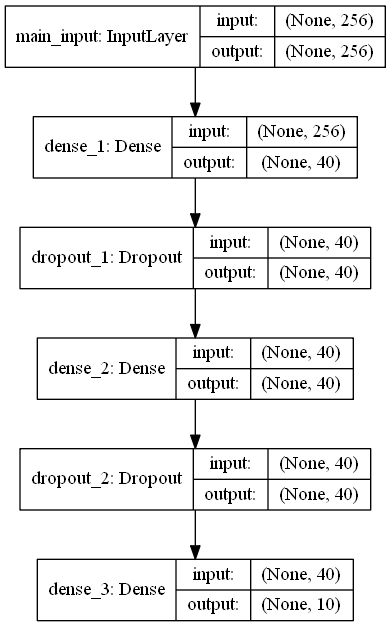

In [13]:
IPython.display.Image("images/semeion_nn.png")

In [ ]:
model.fit(x_train, y_train, 
          batch_size=batchsize,
          epochs=epochsize,
          verbose=1,
          shuffle=shuffle,
          validation_split=0.05)
nn_score = model.evaluate(x_val, y_val)[1]
print(nn_score)

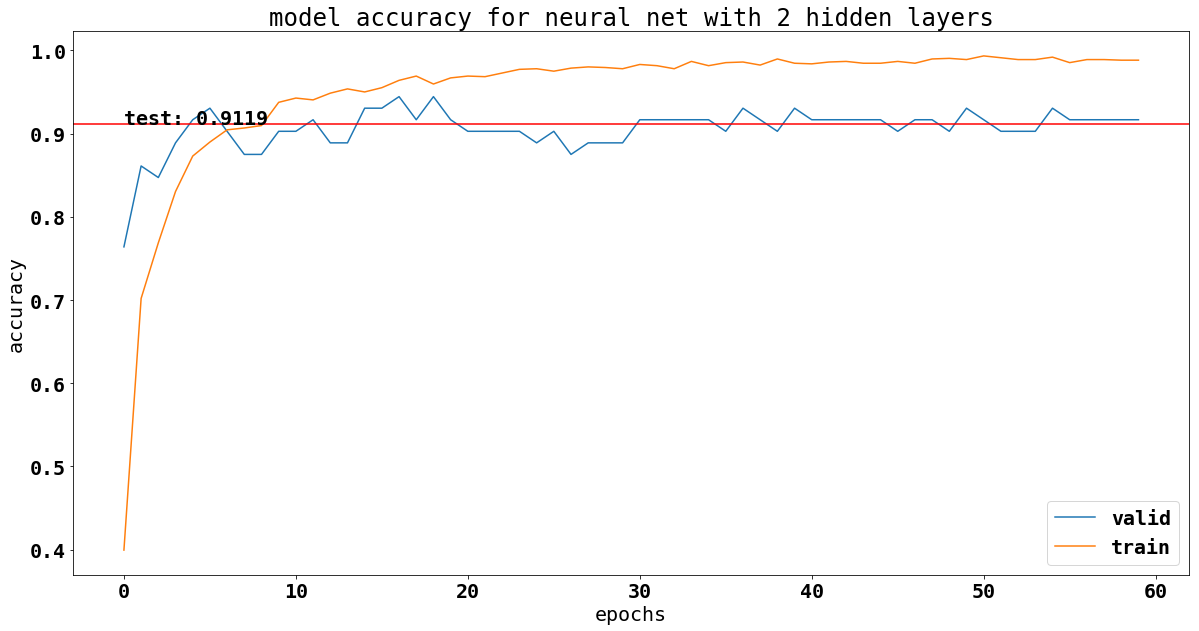

In [15]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.axhline(y=nn_score, c="red")
plt.text(0, nn_score, "test: " + str(round(nn_score, 4)), fontdict=font)
plt.title('model accuracy for neural net with 2 hidden layers')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['valid', 'train'], loc='lower right')
plt.show()

In [16]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_eval, model.predict(x_val).argmax(axis=-1))
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[15  0  0  0  0  1  0  0  0  0]
 [ 0 14  1  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  1  0]
 [ 0  0  0  9  0  0  0  0  0  1]
 [ 0  1  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  1]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  1  0  0  0  0  0 12  0  0]
 [ 1  1  0  0  0  1  0  0 17  0]
 [ 1  0  0  3  0  0  0  0  0 14]]


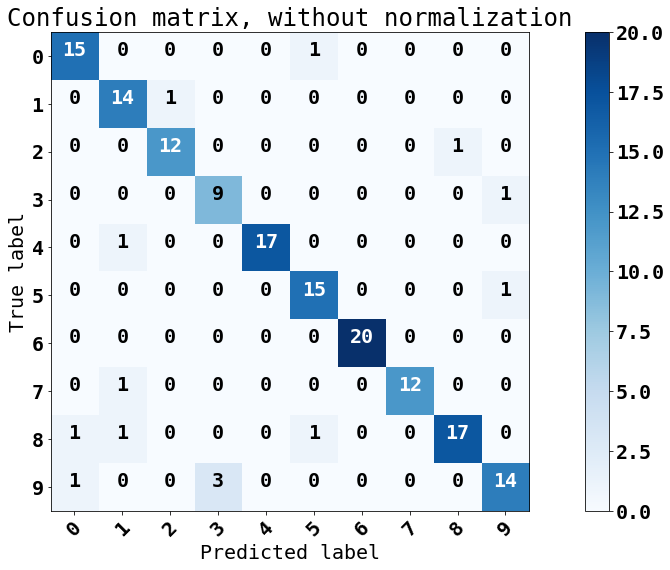

In [18]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix, classes=range(10),
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.94  0.    0.    0.    0.    0.06  0.    0.    0.    0.  ]
 [ 0.    0.93  0.07  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.92  0.    0.    0.    0.    0.    0.08  0.  ]
 [ 0.    0.    0.    0.9   0.    0.    0.    0.    0.    0.1 ]
 [ 0.    0.06  0.    0.    0.94  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.94  0.    0.    0.    0.06]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.08  0.    0.    0.    0.    0.    0.92  0.    0.  ]
 [ 0.05  0.05  0.    0.    0.    0.05  0.    0.    0.85  0.  ]
 [ 0.06  0.    0.    0.17  0.    0.    0.    0.    0.    0.78]]


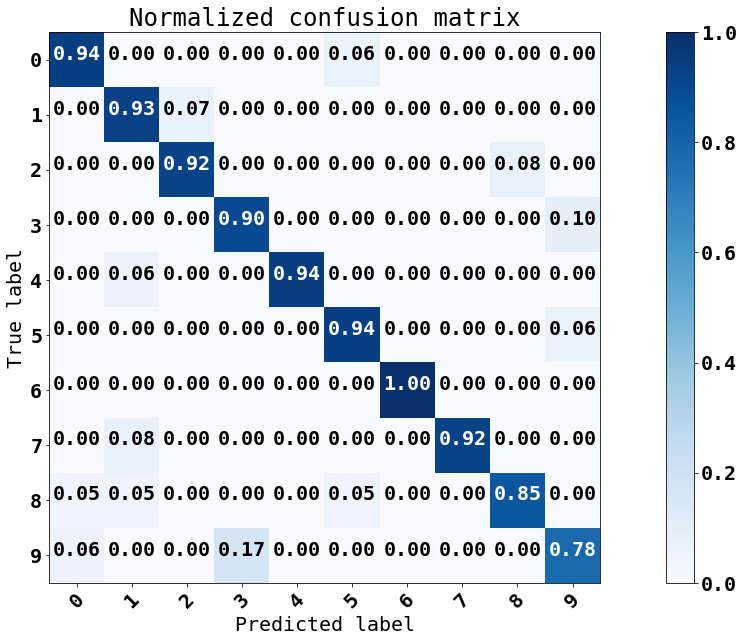

In [19]:
# Plot normalized confusion matrix
plt.figure(figsize=(19,9))
plot_confusion_matrix(cnf_matrix, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

## Whats the best dimensionality reduction with single autoencoder?

In [20]:
# the initial coding dimension s.t. there is no dim reduction at the beginning
encoding_dim = hidden1_dim
result = {'encoding_dim': [], 'auto_classifier_acc': []}

In [ ]:
while encoding_dim > 0:
    main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

    encoding_layer = Dense(encoding_dim
                           ,activation='relu'
                           ,name='encoder'
#                            , kernel_initializer='normal'
                          )
    encoding_layer_output = encoding_layer(main_input)
    decoding_layer_output = Dense(input_dim
                                  ,activation='sigmoid'
                                  ,name='decoder_output'
#                                   ,kernel_initializer='normal'
                                 )(encoding_layer_output)

    x = Dense(hidden1_dim
              ,activation='relu'
#               , kernel_initializer=weights
             )(encoding_layer_output)
    x = Dropout(dropout)(x)
    x = Dense(hidden2_dim
              ,activation='relu'
#               , kernel_initializer=weights
             )(x)
    x = Dropout(dropout)(x)

    classifier_output = Dense(num_classes
                              ,activation='softmax'
                              ,name='main_output'
#                               , kernel_initializer=weights
                             )(x)

    auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

    auto_classifier.compile(optimizer=RMSprop(),
                            loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                            loss_weights={'main_output': .2, 'decoder_output': .8},
                            metrics=['accuracy'])

    auto_classifier.fit({'main_input': x_train},
                        {'main_output': y_train, 'decoder_output': x_train},
                        epochs=epochsize, 
                        batch_size=batchsize,
                        shuffle=shuffle,
                        validation_split=0.05,
                        verbose=0)

    accuracy = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
    result['encoding_dim'].append(encoding_dim)
    result['auto_classifier_acc'].append(accuracy)
    
    encoding_dim -=1
    print(result)

In [22]:
result_df = pd.DataFrame(result)
result_df['neural_net_acc'] = nn_score
result_df.head()

,auto_classifier_acc,encoding_dim,neural_net_acc
0,0.918239,40,0.91195
1,0.899371,39,0.91195
2,0.937107,38,0.91195
3,0.911950,37,0.91195
4,0.911950,36,0.91195


(0.6, 1)

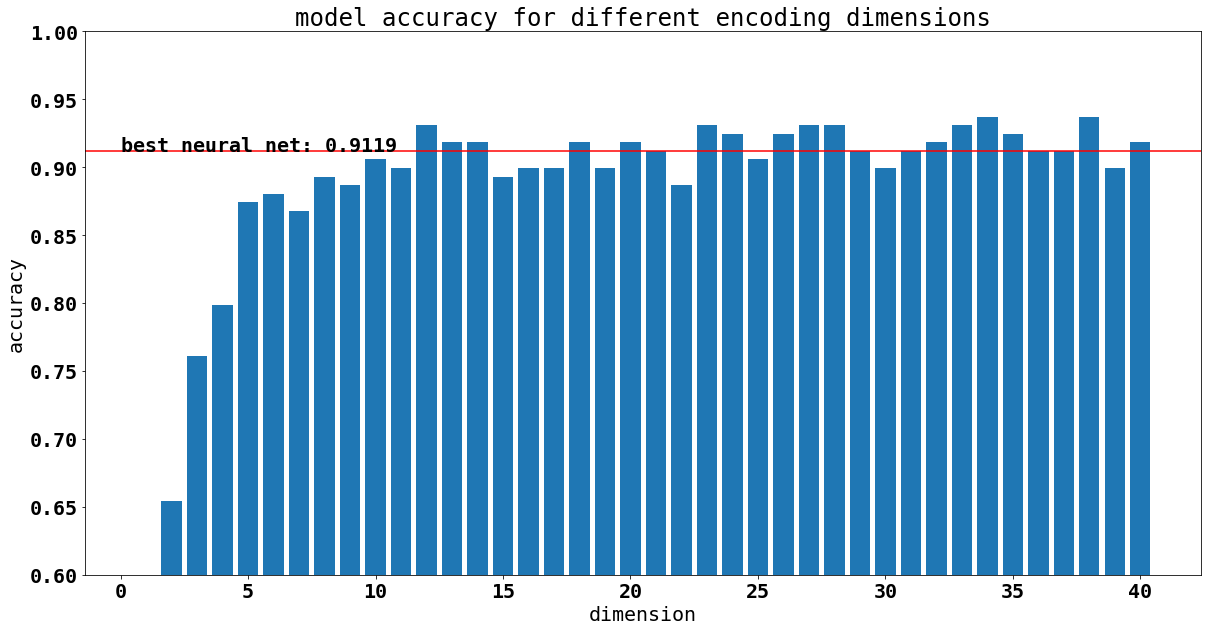

In [23]:
fig = plt.figure(figsize=(20,10))
plt.bar(result_df['encoding_dim'], result_df['auto_classifier_acc'])
plt.axhline(y=result_df['neural_net_acc'][0], c="red")
plt.text(0, result_df['neural_net_acc'][0], "best neural net: " + str(round(result_df['neural_net_acc'][0], 4))
         ,fontdict=font)
plt.title('model accuracy for different encoding dimensions')
plt.ylabel('accuracy')
plt.xlabel('dimension')
plt.ylim(0.6, 1)

In [24]:
result_df.to_csv('results/semeion_results.csv')